# Part A

## Purpose

The following link is the code for manual GradCAM generation for a given layer in VGG16 pretrained model. The task for this part is to generate and visualize GradCAM for two convolution layers prior to the one being used, for any two random images. Moreover, we need to find the sunglasses in a given image of Robert Downey Jr.  

https://colab.research.google.com/drive/10GugXUNI7ztK2joRZUnYyqRrQbYnOQE0

## Load the pre-trained model

In [1]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
import cv2

Using TensorFlow backend.


In [2]:
model = VGG16(weights='imagenet')

W0719 14:57:49.899364 139831423121280 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0719 14:57:49.952186 139831423121280 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0719 14:57:49.960114 139831423121280 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0719 14:57:50.016217 139831423121280 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



553467904/553467096 [==============================] - 6s 0us/step


W0719 14:57:57.213190 139831423121280 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0719 14:57:57.214620 139831423121280 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [3]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## GradCAM and Visualization

### Function to generate GradCAM and visualization

In [0]:
from keras import backend as K
from skimage import io
from google.colab.patches import cv2_imshow

def gradcam_display(img, layer):
  im = io.imread(img)
  im = cv2.resize(im, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
  x = image.img_to_array(im)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer(layer)

  grads = K.gradients(class_output, last_conv_layer.output)[0]
  channels = grads.shape[-1]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(channels):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  heatmap = np.mean(conv_layer_output_value, axis = -1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  heatmap = cv2.resize(heatmap, (im.shape[1], im.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(im, 0.5, heatmap, 0.5, 0)
  
  return np.hstack([im, superimposed_img])


### Visualizing GradCAM for 2nd last layer

In [0]:
image1 = r"https://www.rspcapetinsurance.org.au/rspca/media/images/hero/dog-insurance-hero.jpg"
image2 = r"https://i.ibb.co/txMbrb4/horse.jpg"
image3 = r"https://i.ibb.co/b5qwVBj/ship2.jpg"
images = [image1, image2, image3]

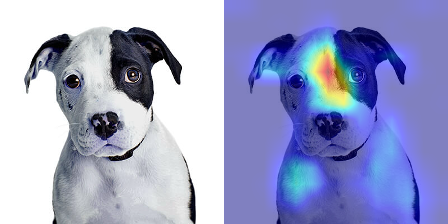

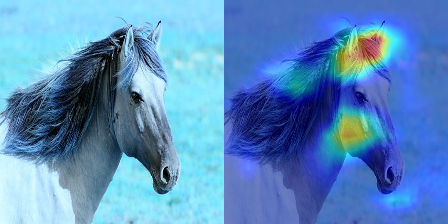

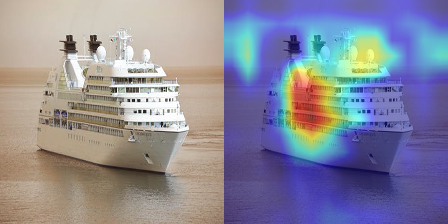

In [52]:
layer = "block5_conv2"

for img in images:
  img_stack = gradcam_display(img, layer)
  cv2_imshow(img_stack)

### Visualizing GradCAM for 3rd last layer

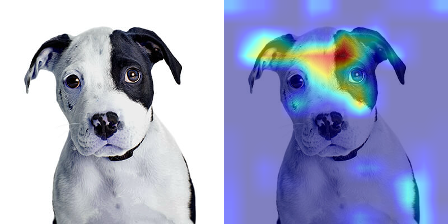

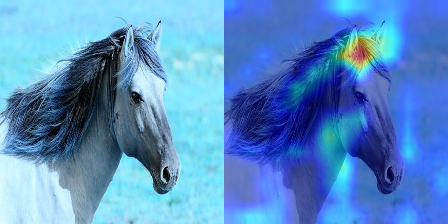

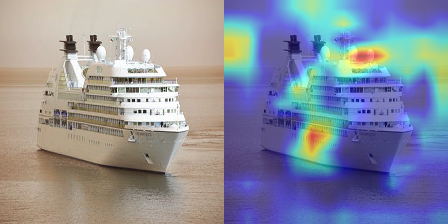

In [54]:
layer = "block5_conv1"

for img in images:
  img_stack = gradcam_display(img, layer)
  cv2_imshow(img_stack)

### Finding Robert Downey's sunglasses

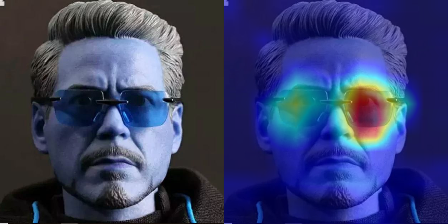

In [56]:
image4 = r"https://i.ibb.co/3BnKryQ/Tony-Stark.jpg"
images = [image4]

layer = "block5_conv3"

for img in images:
  img_stack = gradcam_display(img, layer)
  cv2_imshow(img_stack)

# Part B

## Purpose

The paper https://arxiv.org/pdf/1701.03056.pdf demonstrates the calculation of receptive field in the table 7 on the page 21 (as mentioned below). The objective of the task is to find how the receiptive field got increased from 29 to 45.

## Receptive Field Calculation

![](https://i.ibb.co/cv6fkQH/RF-Table.jpg)

The network is using a zero padding size of one and kernel size of 3 x 3. We will use the following generic formula for receptive field calculation.  

![](https://i.ibb.co/L9NRRKh/Calculation.jpg)


The following table demonstrates the receiptive field calculation for each layer using the above mentioned formula.  
  
The naming convention:  
P = Padding size  
J(in) = Jump in last layer  
J(out) = Jump from current layer  
K = Kernel size  
S = Stide of the convolution

![alt](https://i.ibb.co/J7kSK6w/Receptive-Field.jpg)